<a href="https://colab.research.google.com/github/hkevincho/Pison/blob/main/Pison_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PISON Technical Challenge

## Setup

In [14]:
# Import Packges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# os.getcwd()

In [3]:
# !pip install sktime

In [4]:
!pip install tslearn

     |████████████████████████████████| 793 kB 3.9 MB/s 


In [5]:
!pip install somoclu

     |████████████████████████████████| 6.1 MB 4.2 MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp37-cp37m-linux_x86_64.whl size=481116 sha256=db897a28874ab6a8126a29887d7d10a895b2812c348f7d9f0a8c94014676cb41
  Stored in directory: /root/.cache/pip/wheels/d5/81/eb/22b023e9cac575c4b87d3f9a7318094124e5d8cf90600726fa
Successfully built somoclu


## Import Data

In [6]:
col_names = ['timestamp',
             'channel_0_raw',
             'channel_1_raw',
             'channel_0_high_passed',
             'channel_1_high_passed',
             'quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z',
             'body_movement',
             'repetition_num']
df_raw = pd.read_csv('/content/drive/MyDrive/Technical_challenge/pison_data_interview_2.csv', names=col_names)
print('data shape:', df_raw.shape)
df_raw.head(5)

data shape: (14981, 17)


,timestamp,channel_0_raw,channel_1_raw,channel_0_high_passed,channel_1_high_passed,quaternion_x,quaternion_y,quaternion_z,quaternion_w,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,body_movement,repetition_num
0,1514824.503,12535249,12566283,-11889,17295,0.32196,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.32196,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1
2,1514830.493,12538584,12565279,2757,16008,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
3,1514833.500,12546745,12567024,7504,5644,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.32196,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1


## EDA

In [35]:
# Understand df
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14981 entries, 0 to 14980
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              14981 non-null  float64
 1   channel_0_raw          14981 non-null  int64  
 2   channel_1_raw          14981 non-null  int64  
 3   channel_0_high_passed  14981 non-null  int64  
 4   channel_1_high_passed  14981 non-null  int64  
 5   quaternion_x           14981 non-null  float64
 6   quaternion_y           14981 non-null  float64
 7   quaternion_z           14981 non-null  float64
 8   quaternion_w           14981 non-null  float64
 9   gyroscope_x            14981 non-null  float64
 10  gyroscope_y            14981 non-null  float64
 11  gyroscope_z            14981 non-null  float64
 12  accelerometer_x        14981 non-null  float64
 13  accelerometer_y        14981 non-null  float64
 14  accelerometer_z        14981 non-null  float64
 15  bo

In [30]:
# To understand the distribution of each columns
df_raw.describe()

,timestamp,channel_0_raw,channel_1_raw,channel_0_high_passed,channel_1_high_passed,quaternion_x,quaternion_y,quaternion_z,quaternion_w,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,body_movement,repetition_num
count,1.498100e+04,1.498100e+04,1.498100e+04,14981.000000,1.498100e+04,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000
mean,1.566353e+06,1.253765e+07,1.251263e+07,62.550898,-2.571735e+02,0.263423,0.051271,0.111606,0.444427,6.407260,5.183960,2.237941,0.564972,-10.547218,2.064593,2.003071,1.991456
std,3.096750e+04,4.158465e+05,5.626673e+05,35397.290087,6.523863e+04,0.320534,0.395624,0.588643,0.335159,119.806613,346.986960,110.392775,7.242565,6.138921,6.852529,1.414352,0.815279
min,1.514825e+06,1.040201e+07,1.021268e+07,-422438.000000,-1.053204e+06,-0.897766,-0.777832,-1.000000,0.000000,-481.754550,-1830.891100,-623.763060,-34.382812,-48.960938,-27.765625,0.000000,1.000000
25%,1.538782e+06,1.245908e+07,1.233564e+07,-9221.000000,-1.041900e+04,0.032471,-0.085632,-0.304993,0.107849,-36.425343,-50.077854,-21.709728,-2.011719,-13.261719,-0.542969,1.000000,1.000000
50%,1.566517e+06,1.256078e+07,1.254805e+07,411.000000,3.980000e+02,0.230042,0.072815,0.036194,0.401611,-0.671435,-0.727388,1.678587,-0.363281,-9.816406,1.457031,2.000000,2.000000
75%,1.594422e+06,1.265877e+07,1.269320e+07,9792.000000,1.127500e+04,0.584961,0.329468,0.712097,0.754333,47.727833,50.413570,39.278942,3.582031,-7.398438,5.097656,3.000000,3.000000
max,1.618179e+06,1.419352e+07,1.504110e+07,640848.000000,1.726175e+06,0.905945,0.738708,1.000000,0.999268,427.312380,1828.317300,425.130220,37.671875,7.691406,33.898438,4.000000,3.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb271217890>,
      dtype=object)

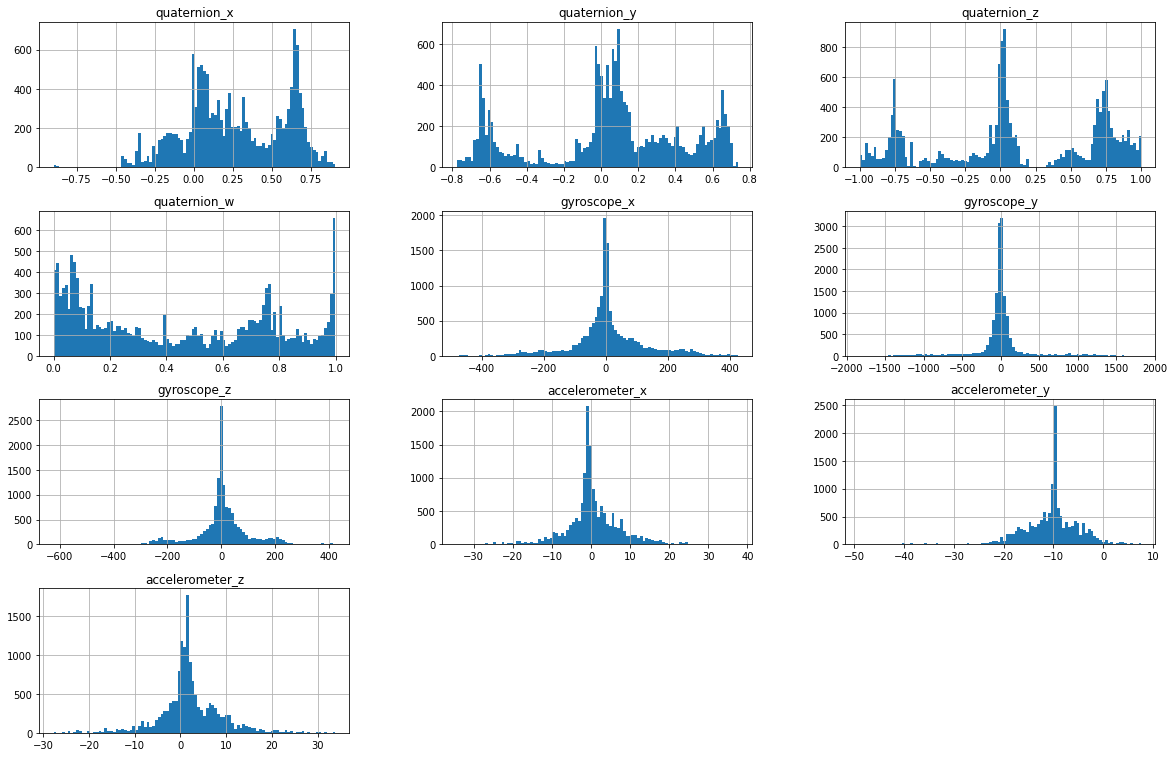

In [34]:
# Histogram of each columns
col_see = [  'quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z']
df_raw.hist(column=col_see, bins=100, layout=(6, 3), figsize=(20, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2a4de1690>,
      dtype=object)

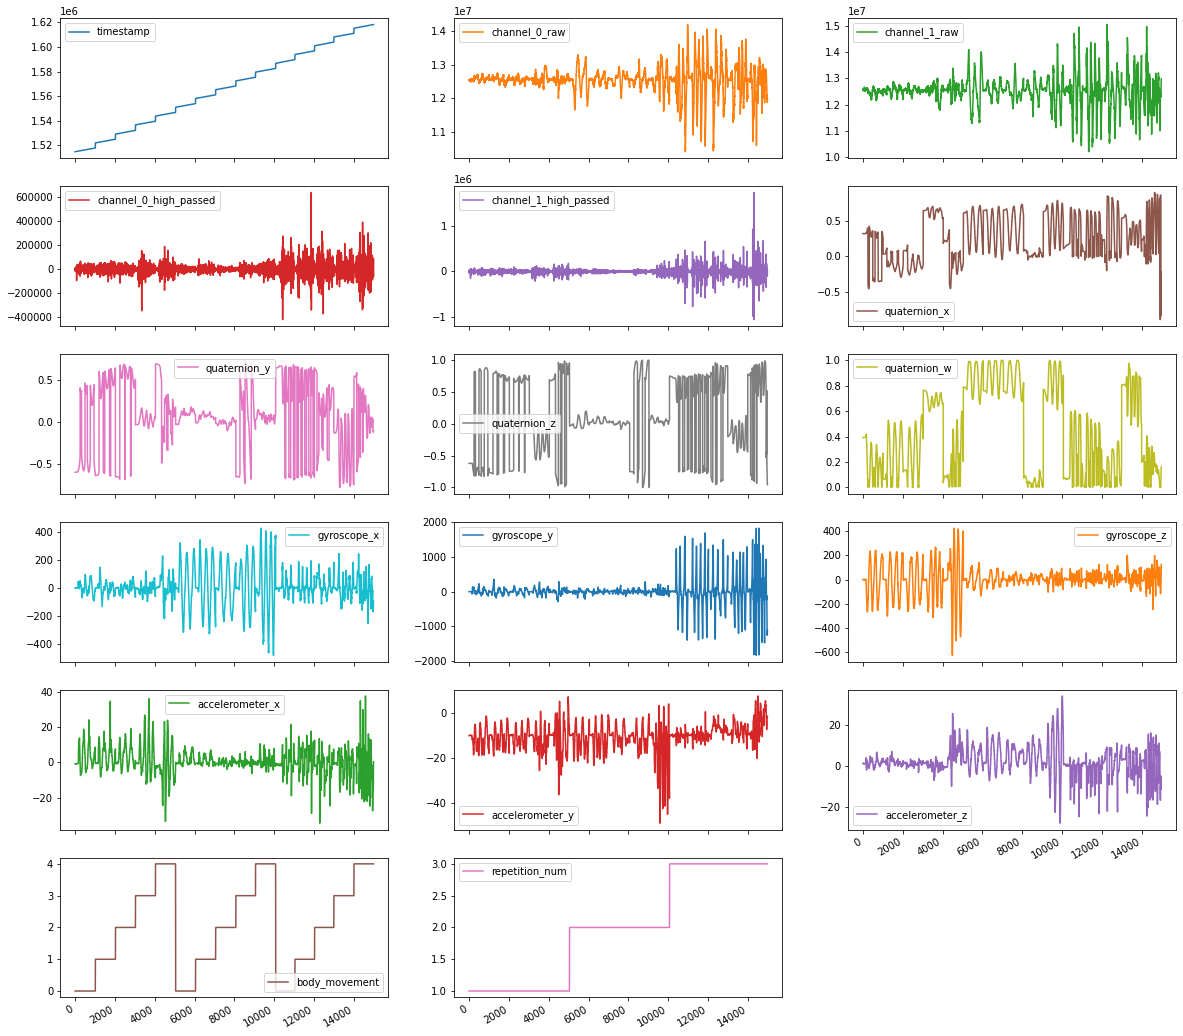

In [7]:
df_raw.plot(subplots=True, layout=(6, 3), figsize=(20, 20))

- The body movement seems to follow repeating pattern. Standing #1, standing #2, walking, walking fast, and running -> Repeat...
- Repetition num lines up with body movement segmentation. First around 5000, and 10,000, then about 15,000

## Data Processing

In [36]:
# Drop non-relevant columns
col_keep = [ 'quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z',
             'body_movement',
             'repetition_num']
df_processed = df_raw[col_keep]

In [37]:
# Normalize data using MinMax Scaler
scaler = MinMaxScaler() # Apply normalization instead of standardization because each feature is not roughly normal
col_scale = ['quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z']
df_processed[col_scale] = pd.DataFrame(scaler.fit_transform(df_processed[col_scale]), columns=df_processed[col_scale].columns)
df_processed.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,quaternion_x,quaternion_y,quaternion_z,quaternion_w,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,body_movement,repetition_num
0,0.676232,0.119491,0.189087,0.392377,0.528467,0.500642,0.595167,0.468015,0.687651,0.470037,0,1
1,0.676232,0.119411,0.189087,0.392316,0.528282,0.500673,0.594687,0.468015,0.687651,0.470037,0,1
2,0.676232,0.119411,0.189117,0.392255,0.528590,0.500673,0.594420,0.468015,0.687651,0.470037,0,1
3,0.676232,0.119411,0.189117,0.392255,0.528590,0.500673,0.594420,0.468015,0.687651,0.470037,0,1
4,0.676232,0.119371,0.189117,0.392194,0.528775,0.500581,0.593993,0.468015,0.687651,0.470037,0,1


In [39]:
# Create unique rep and body list
unique_rep = df_raw['repetition_num'].unique()
unique_body = df_raw['body_movement'].unique()

# Define window to calculate time series characteristics
window = 10

# Calculate time series characteristics
appended_df = []
for i in unique_rep:
  for j in unique_body:
    df_temp = df_processed[(df_processed['repetition_num']==i) & (df_processed['body_movement']==j)]
    df_temp.drop(['repetition_num', 'body_movement'], axis=1, inplace=True)

    # Data operation
    df_temp_mean = df_temp.rolling(window).mean()
    df_temp_mean.rename(columns=lambda s: s+'_mean', inplace=True)

    df_temp_range = df_temp.rolling(window).max() - df_temp.rolling(window).min()
    df_temp_range.rename(columns=lambda s: s+'_range', inplace=True)

    df_temp_var = df_temp.rolling(window).var()
    df_temp_var.rename(columns=lambda s: s+'_var', inplace=True)

    # Merge dataframe
    df_merge = pd.concat([df_temp_mean, df_temp_range, df_temp_var], axis=1)

    # Drop nan in window segment
    df_merge = df_merge.iloc[window-1:, :]

    # Append dataframe
    appended_df.append(df_merge)

# Concatenate final df
final_df = pd.concat(appended_df)

final_df.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

,quaternion_x_mean,quaternion_y_mean,quaternion_z_mean,quaternion_w_mean,gyroscope_x_mean,gyroscope_y_mean,gyroscope_z_mean,accelerometer_x_mean,accelerometer_y_mean,accelerometer_z_mean,quaternion_x_range,quaternion_y_range,quaternion_z_range,quaternion_w_range,gyroscope_x_range,gyroscope_y_range,gyroscope_z_range,accelerometer_x_range,accelerometer_y_range,accelerometer_z_range,quaternion_x_var,quaternion_y_var,quaternion_z_var,quaternion_w_var,gyroscope_x_var,gyroscope_y_var,gyroscope_z_var,accelerometer_x_var,accelerometer_y_var,accelerometer_z_var
9,0.676255,0.119395,0.189102,0.392206,0.528879,0.500537,0.594105,0.467483,0.687913,0.470290,0.000068,0.000121,0.000031,0.000305,0.001416,0.000306,0.001707,0.002656,0.00131,0.001267,1.030538e-09,1.512021e-09,2.589114e-10,8.953463e-09,1.919867e-07,1.810502e-08,3.171012e-07,1.254484e-06,3.051167e-07,2.853601e-07
10,0.676262,0.119383,0.189102,0.392176,0.529002,0.500514,0.593977,0.467218,0.688044,0.470417,0.000068,0.000040,0.000031,0.000244,0.001416,0.000306,0.001227,0.002656,0.00131,0.001267,1.132324e-09,3.782530e-10,2.589114e-10,6.673522e-09,2.307124e-07,1.798812e-08,1.789919e-07,1.646511e-06,4.004657e-07,3.745351e-07
11,0.676269,0.119379,0.189102,0.392151,0.529193,0.500480,0.593881,0.466952,0.688175,0.470544,0.000068,0.000040,0.000031,0.000183,0.001600,0.000336,0.000960,0.002656,0.00131,0.001267,1.132328e-09,2.881927e-10,2.589114e-10,5.015595e-09,2.894323e-07,1.741657e-08,1.198022e-07,1.881726e-06,4.576751e-07,4.280402e-07
12,0.676279,0.119379,0.189099,0.392133,0.529415,0.500414,0.593823,0.466687,0.688306,0.470670,0.000102,0.000040,0.000031,0.000183,0.002216,0.000658,0.000960,0.002656,0.00131,0.001267,1.323143e-09,2.881927e-10,2.485549e-10,4.145124e-09,4.833974e-07,3.249759e-08,8.397855e-08,1.960132e-06,4.767449e-07,4.458752e-07
13,0.676289,0.119379,0.189096,0.392115,0.529636,0.500349,0.593764,0.466421,0.688437,0.470797,0.000102,0.000040,0.000031,0.000122,0.002031,0.000566,0.000533,0.002656,0.00131,0.001267,1.284960e-09,2.881927e-10,2.174855e-10,2.528547e-09,5.682571e-07,3.797145e-08,4.050321e-08,1.881726e-06,4.576751e-07,4.280402e-07
14,0.676299,0.119387,0.189090,0.392102,0.529864,0.500312,0.593748,0.466155,0.688568,0.470924,0.000102,0.000080,0.000061,0.000122,0.002277,0.000566,0.000533,0.002656,0.00131,0.001267,1.017780e-09,7.919638e-10,3.001134e-10,1.865265e-09,6.508017e-07,3.248460e-08,3.490675e-08,1.646511e-06,4.004657e-07,3.745351e-07
15,0.676310,0.119395,0.189084,0.392090,0.530092,0.500275,0.593732,0.465890,0.688699,0.471050,0.000068,0.000080,0.000061,0.000061,0.001970,0.000398,0.000427,0.002656,0.00131,0.001267,5.216021e-10,1.151780e-09,2.999710e-10,8.703620e-10,6.180954e-07,2.400494e-08,2.874116e-08,1.254484e-06,3.051167e-07,2.853601e-07
16,0.676320,0.119407,0.189078,0.392084,0.530307,0.500258,0.593828,0.465624,0.688830,0.471177,0.000068,0.000121,0.000030,0.000061,0.001970,0.000398,0.000907,0.002656,0.00131,0.001267,5.598267e-10,1.961667e-09,2.170583e-10,6.631329e-10,5.989430e-07,2.226172e-08,6.288906e-08,7.056474e-07,1.716282e-07,1.605151e-07
17,0.676323,0.119423,0.189072,0.392084,0.530553,0.500245,0.593993,0.465358,0.688961,0.471304,0.000068,0.000161,0.000061,0.000061,0.002462,0.000398,0.001654,0.000000,0.00000,0.000000,5.216563e-10,3.257709e-09,4.653284e-10,6.631329e-10,6.359850e-07,2.083545e-08,2.206966e-07,0.000000e+00,0.000000e+00,0.000000e+00
18,0.676326,0.119439,0.189066,0.392084,0.530800,0.500231,0.594159,0.465358,0.688961,0.471304,0.000068,0.000161,0.000061,0.000061,0.002031,0.000398,0.001440,0.000000,0.00000,0.000000,4.580446e-10,3.977742e-09,6.308553e-10,6.631329e-10,5.383289e-07,1.898832e-08,3.177335e-07,0.000000e+00,0.000000e+00,0.000000e+00


In [17]:
# # Normalize data using MinMax Scaler
# scaler = MinMaxScaler()
# final_df = scaler.fit_transform(final_df)

In [40]:
# Check df shape
final_df.shape # this is correct as 14981 - 14846 = 135. 9*15 = 135 which is what is missing when doing rolling window of 10

(14846, 30)

In [41]:
# Check that there is no NaN
final_df[final_df.isna().any(axis=1)]

,quaternion_x_mean,quaternion_y_mean,quaternion_z_mean,quaternion_w_mean,gyroscope_x_mean,gyroscope_y_mean,gyroscope_z_mean,accelerometer_x_mean,accelerometer_y_mean,accelerometer_z_mean,quaternion_x_range,quaternion_y_range,quaternion_z_range,quaternion_w_range,gyroscope_x_range,gyroscope_y_range,gyroscope_z_range,accelerometer_x_range,accelerometer_y_range,accelerometer_z_range,quaternion_x_var,quaternion_y_var,quaternion_z_var,quaternion_w_var,gyroscope_x_var,gyroscope_y_var,gyroscope_z_var,accelerometer_x_var,accelerometer_y_var,accelerometer_z_var


## Model Approach 1
Extract time series characteristics and apply Kmeans with Euclidean distance

In [61]:
from sklearn.cluster import KMeans, SpectralClustering

In [108]:
# Perform PCA to two dimensions to visualize
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # n_comp = 2 because first two pc explain most variance and also then can be visualized in 2D graph
reduced_data = pca.fit_transform(final_df)

PCA explained variance ratio: two is enough

array([0.34661894, 0.28264972, 0.08508879, 0.05730619, 0.05438014,
       0.03991662, 0.02665648, 0.02138226, 0.02094469, 0.01733769])

Text(0, 0.5, 'WCSS')

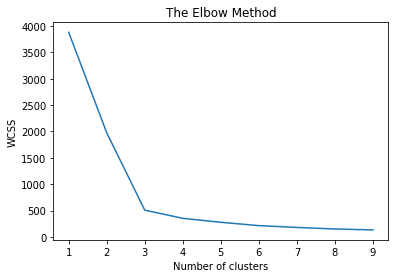

In [109]:
# Perform KMeans and see elbow graph using reduced_data
wcss=[] # within-cluster sum of square
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(reduced_data)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

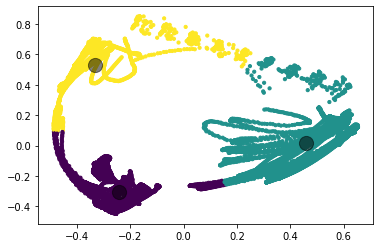

In [110]:
# Visualizing clusters from reduced data using kmeans
kmeans = KMeans(n_clusters=3) # n=3 chosen from elbow method above
kmeans.fit(reduced_data)
y_kmeans = kmeans.predict(reduced_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_kmeans, s=10, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [216]:
# Find most similar sample from data
from scipy.spatial import distance

center_list = []
for i in range(len(centers)):
  ary = distance.cdist(reduced_data, centers[i].reshape((1, centers[i].shape[0])), metric='euclidean')

  # Find corresponding min location
  center_num = reduced_data[np.argmin(ary)]

  # Bring back this center to original dimension
  center_num_orig = pca.inverse_transform(center_num)

  # Append
  center_list.append(center_num_orig)

center_df = pd.DataFrame(center_list, columns=final_df.columns)

How similar are centroid to actual value from data?

real center 0: [-0.24371167 -0.30367961]

most similar point from data: [-0.24289968 -0.30412776]

In [217]:
center_df

,quaternion_x_mean,quaternion_y_mean,quaternion_z_mean,quaternion_w_mean,gyroscope_x_mean,gyroscope_y_mean,gyroscope_z_mean,accelerometer_x_mean,accelerometer_y_mean,accelerometer_z_mean,quaternion_x_range,quaternion_y_range,quaternion_z_range,quaternion_w_range,gyroscope_x_range,gyroscope_y_range,gyroscope_z_range,accelerometer_x_range,accelerometer_y_range,accelerometer_z_range,quaternion_x_var,quaternion_y_var,quaternion_z_var,quaternion_w_var,gyroscope_x_var,gyroscope_y_var,gyroscope_z_var,accelerometer_x_var,accelerometer_y_var,accelerometer_z_var
0,0.751924,0.521929,0.498559,0.806091,0.541031,0.502643,0.596385,0.480070,0.662204,0.492222,0.012067,-0.006972,-0.016693,0.017728,0.029253,0.016711,0.018214,0.024023,0.033757,0.026393,-0.000351,-0.003040,-0.004320,0.000096,0.000178,0.000109,0.000093,0.000481,0.000793,0.000414
1,0.560184,0.794842,0.858182,0.219204,0.547372,0.502024,0.596098,0.469561,0.694682,0.471313,0.030612,0.054328,0.060695,0.033665,0.024576,0.032472,0.023668,0.037780,0.027173,0.029823,0.001148,0.006059,0.008538,0.000329,0.000156,0.000886,0.000159,0.001304,0.000449,0.000843
2,0.585463,0.177444,0.156685,0.159463,0.512228,0.499447,0.597417,0.520497,0.679054,0.489154,0.027747,0.082538,0.097555,0.026118,0.020398,0.030439,0.024015,0.037941,0.020514,0.024530,0.001576,0.010982,0.015275,0.000189,0.000114,0.000436,0.000163,0.001117,0.000244,0.000501


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


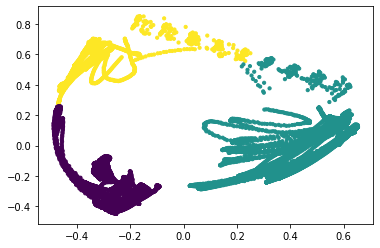

In [65]:
# Visualizing clusters from reduced data using spectral clustering
kmeans = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans')
y_kmeans = kmeans.fit_predict(reduced_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_kmeans, s=10, cmap='viridis')

In [79]:
# Try using t-distributed stochastic neighbor embedding (t-SNE)
from sklearn.manifold import TSNE

# Project the data
tsne = TSNE(n_components=2, init='random', random_state=0)
reduced_proj = tsne.fit_transform(final_df)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0, 0.5, 'WCSS')

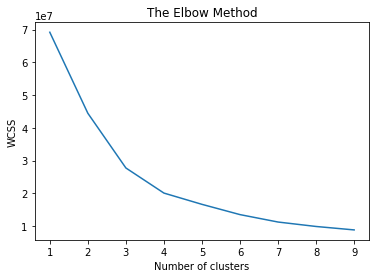

In [80]:
# Determine # of clusters
wcss=[] # within-cluster sum of square
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(reduced_proj)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [82]:
# Compute the clusters
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(reduced_proj)

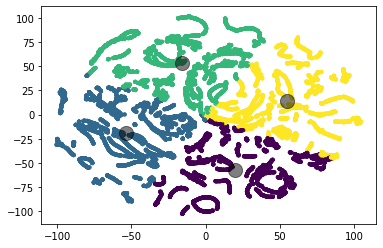

In [83]:
# Visualizing clusters from t-SNE
plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1], c=clusters, s=10, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

Text(0, 0.5, 'WCSS')

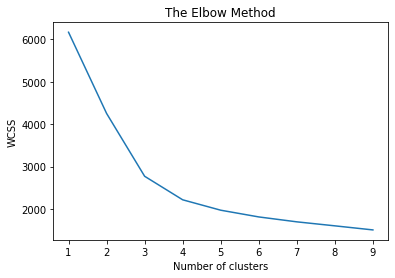

In [49]:
# Determine cluster num from elbow graph using final_df
wcss=[]
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(final_df)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

## Model Approach 2
Use time series kmeans clustering with DTW (Dynamic Time Warping)

In [16]:
from tslearn.clustering import TimeSeriesKMeans

In [93]:
df_train = df_processed.drop(['repetition_num', 'body_movement'], axis=1)
df_train.shape

(14981, 10)

In [ ]:
from tslearn.generators import random_walks
X = random_walks(n_ts=50, sz=32, d=5)
X

In [101]:
X[0]

array([[-0.6668486 ,  0.59693824, -0.44108166,  0.04086284,  1.34658562],
       [ 0.3039647 , -0.57295784, -1.75784319, -0.41641456,  1.71092301],
       [ 1.00811854, -0.14100649,  0.18941369, -1.15817539,  3.34711039],
       [ 1.06199238, -0.3520653 , -1.23907288, -0.4294247 ,  2.51842641],
       [ 1.77730817, -2.67157195, -0.87407731, -0.06438429,  3.24515829],
       [ 2.26666774, -4.21461914, -2.214065  ,  0.84531593,  4.96081145],
       [ 1.95815834, -5.00021047, -4.01614591, -0.1590539 ,  2.06902295],
       [ 2.1642153 , -6.2726465 , -5.68572249,  0.64597854,  2.12410538],
       [ 1.992532  , -6.10223863, -7.18754777, -1.01011557,  1.62300197],
       [ 3.13239508, -6.83737514, -7.0888868 , -1.78802929,  2.28379597],
       [ 2.52296075, -4.73089507, -8.49136784, -2.27824738,  3.2163245 ],
       [ 1.16155157, -3.64117319, -9.27938664, -3.53279304,  2.18017324],
       [ 1.04261951, -2.90137512, -8.64389561, -5.59247386,  3.30971119],
       [ 1.55175002, -1.63658744, -8.4

In [ ]:
# I need to create time series segments of 10 to generate bunch of time series segments. Then try to find if there is something similar
split_num = np.round(df_train.shape[0]/10)
all_splits = np.array_split(df_train, split_num)
all_splits = np.array(all_splits)

In [68]:
seed = 1
model = TimeSeriesKMeans(n_clusters=3, metric="dtw",
                         max_iter=10, random_state=seed)
model.fit(all_splits)

TimeSeriesKMeans(max_iter=10, metric='dtw', random_state=1)

In [ ]:
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(df_train)

In [102]:
model.cluster_centers_.shape

(3, 10, 1)

In [ ]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

## Model Approach 3
SOM

In [40]:
from mpl_toolkits.mplot3d import Axes3D
import somoclu
%matplotlib inline  

In [ ]:
n_rows, n_columns = 100, 160
som = somoclu.Somoclu(n_columns, n_rows, data=final_df)
%time som.train()

In [ ]:
som.view_component_planes()

In [ ]:
colors = ["red"] * 5000
colors.extend(["green"] * 5000)
colors.extend(["blue"] * 5000)
som.view_umatrix(bestmatches=True, bestmatchcolors=colors)

## Trying Stuff

In [48]:
# model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=10)
# model.fit(df_raw)

In [49]:
# model.cluster_centers_

In [38]:
df_raw[(df_raw['repetition_num']==1) & (df_raw['body_movement']==0)]

,timestamp,channel_0_raw,channel_1_raw,channel_0_high_passed,channel_1_high_passed,quaternion_x,quaternion_y,quaternion_z,quaternion_w,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,body_movement,repetition_num
0,1514824.503,12535249,12566283,-11889,17295,0.321960,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.218750,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.321960,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.218750,0,1
2,1514830.493,12538584,12565279,2757,16008,0.321960,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.218750,0,1
3,1514833.500,12546745,12567024,7504,5644,0.321960,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.218750,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.321960,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.218750,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,1517850.217,12673747,12351166,-963,-3734,0.256470,-0.610168,-0.703491,0.258911,-20.254953,22.940693,180.224320,5.277344,-13.796875,3.710938,0,1
1010,1517853.155,12666856,12368175,-2388,6356,0.256470,-0.610168,-0.703491,0.258911,-20.254953,22.940693,180.224320,5.277344,-13.796875,3.710938,0,1
1011,1517856.157,12672234,12356511,6304,-10761,0.251404,-0.612915,-0.701233,0.263611,-18.576366,18.968037,176.363570,5.277344,-13.796875,3.710938,0,1
1012,1517859.160,12683170,12381392,10831,18598,0.246399,-0.615479,-0.698975,0.268188,-16.618013,18.464460,171.663530,5.277344,-13.796875,3.710938,0,1


SKTIME Example

In [5]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline

from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket

In [8]:
X_train, y_train = load_arrow_head(split="train", return_X_y=True)

In [21]:
X_train.iloc[0]

dim_0    0     -1.9630
1     -1.9578
2     -1.9561
3   ...
Name: 0, dtype: object

In [20]:
X_train.head()

,dim_0
0,0 -1.9630 1 -1.9578 2 -1.9561 3 ...
1,0 -1.7746 1 -1.7740 2 -1.7766 3 ...
2,0 -1.8660 1 -1.8420 2 -1.8350 3 ...
3,0 -2.0738 1 -2.0733 2 -2.0446 3 ...
4,0 -1.7463 1 -1.7413 2 -1.7227 3 ...


In [27]:
X_train['dim_0'][0]

0     -1.9630
1     -1.9578
2     -1.9561
3     -1.9383
4     -1.8967
        ...  
246   -1.8413
247   -1.8843
248   -1.9054
249   -1.9239
250   -1.9092
Length: 251, dtype: float64

Tslearn Example

In [15]:
from tslearn.generators import random_walks
X = random_walks(n_ts=50, sz=32, d=1)

In [21]:
X.shape

(50, 32, 1)

In [17]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0).fit(X)
km.cluster_centers_.shape
km_dba = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, max_iter_barycenter=5, random_state=0).fit(X)
km_dba.cluster_centers_.shape

(3, 32, 1)

In [ ]:
km_dba.cluster_centers_

## Trying More Stuff

In [50]:
# Import Stuff
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

In [52]:
# Processing
seed = 0
np.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = X_train[y_train < 4]  # Keep first 3 classes
np.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# Make time series shorter
X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

Euclidean k-means
16.434 --> 9.437 --> 9.437 --> 


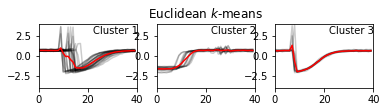

In [53]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [ ]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

In [ ]:
dba_km.cluster_centers_.shape

In [ ]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()